In [6]:
import sys, os

sys.path.append(os.path.abspath('..'))

In [7]:
from torch import empty, Tensor

In [8]:
import pandas as pd
import seaborn as sns
import math

In [9]:
from src.utils import generate, load_dataset, standardized

## Testing data generation

In [5]:
train_input, train_target, test_input, test_target = load_dataset(1000, standardize=True)

In [6]:
df = pd.DataFrame(train_input.tolist())

In [7]:
df['target'] = train_target.tolist()
df.columns = ['x', 'y', 'target']

<AxesSubplot:xlabel='x', ylabel='y'>

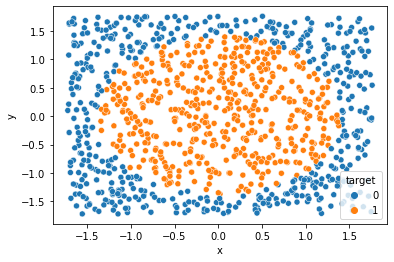

In [8]:
sns.scatterplot(data=df, x='x', y='y', hue='target')

## Testing loss

In [12]:
from torch import tensor

In [27]:
from src.module import Module


class MSELoss(Module):
    def __init__(self):
        super().__init__()

    def forward(self, prediction, target):
        
        print(prediction)
        print(target)
        
        self.prediction = prediction.view(-1)
        self.target = target
        return (prediction - target).pow(2).mean()

    def backward(self):
        return 2 * (self.prediction - self.target) / (self.prediction.size(0))

In [28]:
prediction = tensor([[-0.4433],
        [-0.2356],
        [-0.2109],
        [-0.1666],
        [-0.3752],
        [-0.0956],
        [-0.3019],
        [-0.0784],
        [-0.2483],
        [-0.0612]])
target = tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1])

In [29]:
criterion = MSELoss()

In [30]:
criterion(prediction, target)

tensor([[-0.4433],
        [-0.2356],
        [-0.2109],
        [-0.1666],
        [-0.3752],
        [-0.0956],
        [-0.3019],
        [-0.0784],
        [-0.2483],
        [-0.0612]])
tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1])


tensor(1.0741)

In [31]:
criterion.backward()

tensor([-0.0887, -0.2471, -0.2422, -0.2333, -0.0750, -0.2191, -0.0604, -0.2157,
        -0.2497, -0.2122])